In [86]:
import os
import tempfile
import shutil
from typing import List
from cog import BasePredictor, Path, Input, BaseModel

from openpsg.utils.utils import show_result
from mmdet.apis import init_detector, inference_detector
from mmcv import Config
import mmcv
from mmdet.datasets.coco_panoptic import INSTANCE_OFFSET
from detectron2.utils.colormap import colormap
from detectron2.utils.visualizer import VisImage, Visualizer

from matplotlib import pyplot as plt
import torch
import numpy as np
import random
from panopticapi.utils import rgb2id
import PIL
import cv2
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
class ModelOutput(BaseModel):
    image: Path
    
device = torch.device('cuda:0')
model_ckt = "./work_dirs/checkpoints/epoch_60.pth"
cfg = Config.fromfile("configs/psgtr/psgtr_r50_psg_inference.py")
model = init_detector(cfg, model_ckt, device="cpu").cuda(device)

load checkpoint from local path: ./work_dirs/checkpoints/epoch_60.pth


/home/mini/miniconda3/envs/openpsg/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


window-other beside wall-stone
cat sitting on window-other
cat beside wall-stone
window-other in wall-stone
cat sitting on door-stuff
wall-stone attached to cat
wall-stone attached to window-other
cat beside wall-stone
cat on window-other


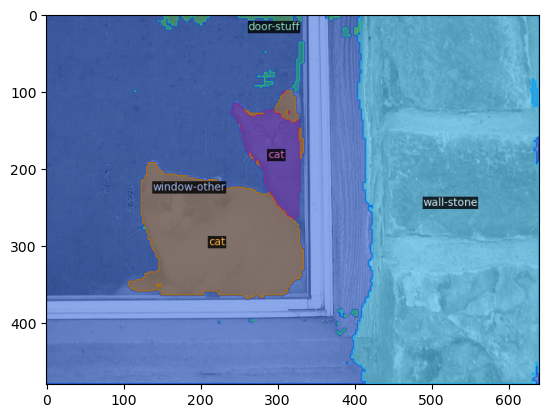

In [4]:
# out_path = Path(tempfile.mkdtemp()) / "output.png"
# out_path = './tmp/total_predict_img/output.png'
# out_dir = "./tmp"
# num_rel = Input(default=5,ge=1,le=20)

image = '../dataset/coco/test2017/000000000968.jpg'
num_rel = 10

List[ModelOutput]
input_image = mmcv.imread(str(image))
result = inference_detector(model, input_image)
show_result(
    image,
    result,
    is_one_stage=True,
    num_rel=num_rel,
    show=True,
    show_rel = True,
)

In [3]:
# video data download
video_anno = pd.read_csv('./sample_data/video_anno.csv')
for row in range(len(video_anno)):
    video_name = video_anno['title'][row]
    video_url = video_anno['download'][row]
    vid = cv2.VideoCapture(video_url)

In [25]:
def get_colormap(num_colors: int):
    return (np.resize(colormap(), (num_colors, 3))).tolist()
def get_result(img, result, is_one_stage, num_rel):
    img = mmcv.imread(img)
    img = img.copy()  # (H, W, 3)
    img_h, img_w = img.shape[:-1]

    # Decrease contrast
    img = PIL.Image.fromarray(img)
    converter = PIL.ImageEnhance.Color(img)
    img = converter.enhance(0.01)

    # Draw masks
    pan_results = result.pan_results

    ids = np.unique(pan_results)[::-1]
    num_classes = 133
    legal_indices = (ids != num_classes)  # for VOID label
    ids = ids[legal_indices]

    # Get predicted labels
    labels = np.array([id % INSTANCE_OFFSET for id in ids], dtype=np.int64)
    labels = [model.CLASSES[l] for l in labels]

    # For psgtr
    rel_obj_labels = result.labels
    rel_obj_labels = [model.CLASSES[l - 1] for l in rel_obj_labels]

    # (N_m, H, W)
    segms = pan_results[None] == ids[:, None, None]
    # Resize predicted masks
    segms = [
        mmcv.image.imresize(m.astype(float), (img_w, img_h)) for m in segms
    ]
    # One stage segmentation
    masks = result.masks

    # Choose colors for each instance in coco
    colormap_coco = get_colormap(
        len(masks)) if is_one_stage else get_colormap(len(segms))
    colormap_coco = (np.array(colormap_coco) / 255).tolist()

    # Viualize masks
    viz = Visualizer(img)
    viz.overlay_instances(
        labels=rel_obj_labels if is_one_stage else labels,
        masks=masks if is_one_stage else segms,
        assigned_colors=colormap_coco,
    )
    viz_img = viz.get_output().get_image()

    # Exclude background class
    rel_dists = result.rel_dists[:, 1:]
    # rel_dists = result.rel_dists
    # Filter out relations
    if len(rel_dists) < num_rel:
        n_rel_topk = len(rel_dists)
    else:
        n_rel_topk = num_rel
    rel_scores = rel_dists.max(1)
    # rel_scores = result.triplet_scores
    # Extract relations with top scores
    rel_topk_idx = np.argpartition(rel_scores, -n_rel_topk)[-n_rel_topk:]
    rel_labels_topk = rel_dists[rel_topk_idx].argmax(1)
    rel_pair_idxes_topk = result.rel_pair_idxes[rel_topk_idx]
    relations = np.concatenate(
        [rel_pair_idxes_topk, rel_labels_topk[..., None]], axis=1)
    return viz_img, rel_obj_labels, relations

In [79]:
# vid.get(cv2.CAP_PROP_FRAME_WIDTH), vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
num_rel = 10
output = {}
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

# vid = cv2.VideoCapture('sample_data/man_running_at_the_beach_122612076.mp4')
video_anno = pd.read_csv('./sample_data/video_anno.csv')
for row in range(len(video_anno)):
    video_name = video_anno['title'][row]
    video_url = video_anno['download'][row]
    vid = cv2.VideoCapture(video_url)
    max = vid.get(cv2.CAP_PROP_FRAME_COUNT)
    height = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    width = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)

    temp = []
    pred_video = cv2.VideoWriter('./sample_data/pred_'+video_name+'.mp4', fourcc, 30.0, (int(width), int(height)))
    with tqdm(total=max) as pbar:
        while(vid.isOpened()):
            ret, frame = vid.read()
            pbar.update(1)
            if ret == True:
                # image = torch.tensor(frame).transpose(1,0).numpy()
                image = frame
                result = inference_detector(model, image)
                viz_img, labels, relations = get_result(
                    frame,
                    result,
                    is_one_stage=True,
                    num_rel=num_rel
                )
                viz_img = cv2.resize(viz_img, (int(width), int(height)))
                temp.append({'viz_image': viz_img, 'labels': labels, 'relations': relations})
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
            pred_video.write(viz_img)
    pred_video.release()
    output[video_name] = temp

682it [06:39,  1.71it/s]                           
481it [06:07,  1.31it/s]                           
570it [06:11,  1.54it/s]                           
206it [02:14,  1.53it/s]                           
280it [02:19,  2.01it/s]                           
331it [03:50,  1.43it/s]                           
424it [04:11,  1.69it/s]                           
280it [02:30,  1.85it/s]                           
592it [07:04,  1.39it/s]                           
369it [03:29,  1.76it/s]                           


In [125]:
#한 영상에 특정 class가 몇 번 나오는지 count
output_merge = {}
for key in output.keys():
    count = 0
    d = []
    labels = [i['labels'] for i in output[key]]
    labels = [x for y in labels for x in y]
    labels_cnt = dict(Counter(labels))
    output_merge[key] = [len(output[key]), labels_cnt]

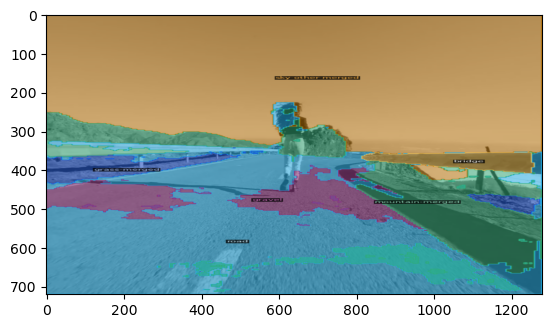

In [72]:
plt.imshow(cv2.resize(output['Woman running down a road'][0]['viz_image'], (128, 720)))

In [82]:
model.CLASSES

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush',
 'banner',
 'blanket',
 'bridge',
 'cardboard',
 'counter',

In [8]:
# # rel_dists = result.rel_dists
# # rel_scores = result.triplet_scores
# # Extract relations with top scores

# rel_dists = result.rel_dists
# rel_scores = rel_dists.max(1)
# rel_topk_idx = np.argpartition(rel_scores, -num_rel)[-num_rel:]
# rel_labels_topk = rel_dists[rel_topk_idx].argmax(1)
# rel_pair_idxes_topk = result.rel_pair_idxes[rel_topk_idx]
# relations = np.concatenate(
#     [rel_pair_idxes_topk, rel_labels_topk[..., None]], axis=1)
# rel_obj_labels = [model.CLASSES[i-1] for i in result.labels]

ValueError: kth(=-1) out of bounds (9)

In [9]:
# for i, r in enumerate(relations):
#     s_idx, o_idx, rel_id = r
#     s_label = rel_obj_labels[s_idx]
#     o_label = rel_obj_labels[o_idx]
#     rel_label = model.PREDICATES[rel_id]
#     print(s_label, rel_label, o_label)

NameError: name 'relations' is not defined

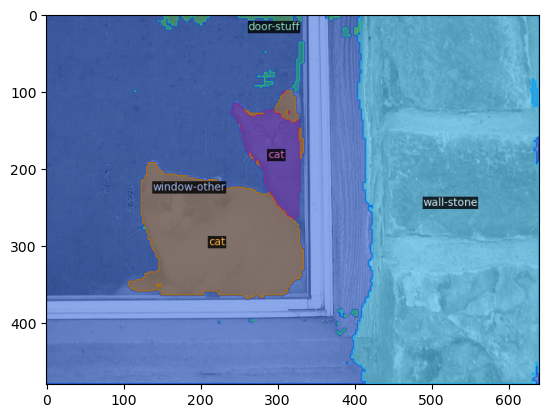

In [28]:
# output = []
# output.append(str(out_path))
# out_dir = './tmp/total_predict_img/'
# for i, img_path in enumerate(os.listdir(out_dir)):
#     img = mmcv.imread(os.path.join(out_dir, img_path))
#     plt.imshow(img)
# # shutil.rmtree(out_dir) 폴더 삭제 하는 코드